<a href="https://colab.research.google.com/github/LocNguyenPV/AI_CatAndDog/blob/main/AI_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project AI
## Name: Nguyen Phuoc Vinh Loc
## Code: MSE23026
## Class: MSE09
## Subject: Artificial intelligence


---

## Overview


1.   Import lib
2.   Load dataset and prepocessing
3.   Build model
4.   Train, test and compare


## 1. Import lib

In [1]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
from google.colab import files
from keras.preprocessing import image

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Python/AI/Final Project

/content/drive/MyDrive/Python/AI/Final Project


In [4]:
train_folder = './Data/train'
valid_folder = './Data/validation'

In [5]:
tf.__version__

'2.6.0'

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-09-29 16:23:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 142.251.5.128, 74.125.206.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  42.3MB/s    in 2.0s    

2021-09-29 16:24:00 (42.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [8]:
!pip install -q tensorflowjs

     |████████████████████████████████| 64 kB 2.5 MB/s 


In [9]:
import tensorflowjs as tfjs

## 2. Load data and processing

**Notes:** I will use ImageDataGenerator to load data from my drive with path which one define before and use function *flow_from_directory* for make the label, it will base on number of folder in train folder to make number of label. Right here, I have two folder (cat, dog), so it will have 2 label

In [10]:
# Because data train don't have to much so I will make some random option to train more effect
train_generator = ImageDataGenerator(rescale=1/255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)
valid_generator = ImageDataGenerator(rescale=1/255)

In [11]:
generate_train_data = train_generator.flow_from_directory(
    train_folder,
    target_size = (150, 150),
    batch_size = 128,
    class_mode='binary'
)

Found 2021 images belonging to 2 classes.


In [12]:
generate_valid_data = valid_generator.flow_from_directory(
    valid_folder,
    target_size = (150, 150),
    batch_size = 128,
    class_mode='binary'
)

Found 1025 images belonging to 2 classes.


In [13]:
generate_train_data

## 3. Build model
Right here I will have two model, one is manual mode made by me, another I will use transfer learning with *Inception* model which one have train by google
* Model Manual:
  * Train Parameters: 9,495,809
  * Non-train: 1,248
  * **Total**: 9,497,057
* Model Transfer:
  * Train Parameters: 38,537,217
  * Non-train: 8,975,264
  * **Total**: 47,512,481
* Optimizer: RMSprop

**Notes:** In build model, I will use dropout with 25% in between Conv and 50% before last Dense. It will avoid make model overfitting


### 3.1) Manual Model

In [14]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(2, 2))
# Add a dropout rate of 0.25
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(2, 2))
# Add a dropout rate of 0.25
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1))
# Add a dropout rate of 0.5
model.add(Dropout(0.5))
# Add a final sigmoid layer for classification
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['acc'])
      

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0

### 3.2) Transfer Model

In [15]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [16]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

In [17]:
for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [18]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model_transfer = Model(pre_trained_model.input, x)
model_transfer.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['acc'])

In [19]:
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_4[0][0]      
______________________________________________________________________________________________

## 4. Train, test and compare

In [20]:
# initial epochs to train for
EPOCHS = 15
BACH_SIZE = 32

In [22]:
# Fitting the CNN to the images
h = model.fit(
    generate_train_data,
    epochs = EPOCHS,
    batch_size=BACH_SIZE,
    verbose = 1,
    validation_data = generate_valid_data
)

Epoch 1/15
16/16 [==============================] - 38s 2s/step - loss: 0.9472 - acc: 0.5715 - val_loss: 0.6915 - val_acc: 0.5366
Epoch 2/15
16/16 [==============================] - 36s 2s/step - loss: 0.9454 - acc: 0.5769 - val_loss: 0.6927 - val_acc: 0.5288
Epoch 3/15
16/16 [==============================] - 36s 2s/step - loss: 0.9084 - acc: 0.5977 - val_loss: 0.6836 - val_acc: 0.5385
Epoch 4/15
16/16 [==============================] - 36s 2s/step - loss: 0.8849 - acc: 0.5952 - val_loss: 0.6845 - val_acc: 0.5395
Epoch 5/15
16/16 [==============================] - 36s 2s/step - loss: 0.8312 - acc: 0.6126 - val_loss: 0.6864 - val_acc: 0.5298
Epoch 6/15
16/16 [==============================] - 36s 2s/step - loss: 0.8415 - acc: 0.6170 - val_loss: 0.7131 - val_acc: 0.5093
Epoch 7/15
16/16 [==============================] - 36s 2s/step - loss: 0.8089 - acc: 0.6165 - val_loss: 0.7516 - val_acc: 0.5063
Epoch 8/15
16/16 [==============================] - 36s 2s/step - loss: 0.8171 - acc: 0.61

In [23]:
h_transfer = model_transfer.fit(
    generate_train_data,
    epochs = EPOCHS,
    batch_size=BACH_SIZE,
    verbose = 1,
    validation_data = generate_valid_data
)

Epoch 1/15
16/16 [==============================] - 45s 2s/step - loss: 0.7746 - acc: 0.7724 - val_loss: 0.1836 - val_acc: 0.9190
Epoch 2/15
16/16 [==============================] - 37s 2s/step - loss: 0.2547 - acc: 0.8902 - val_loss: 0.2188 - val_acc: 0.9093
Epoch 3/15
16/16 [==============================] - 38s 2s/step - loss: 0.2122 - acc: 0.9065 - val_loss: 0.1113 - val_acc: 0.9610
Epoch 4/15
16/16 [==============================] - 38s 2s/step - loss: 0.2145 - acc: 0.9085 - val_loss: 0.1829 - val_acc: 0.9200
Epoch 5/15
16/16 [==============================] - 37s 2s/step - loss: 0.2165 - acc: 0.9075 - val_loss: 0.0989 - val_acc: 0.9659
Epoch 6/15
16/16 [==============================] - 38s 2s/step - loss: 0.1566 - acc: 0.9352 - val_loss: 0.1039 - val_acc: 0.9649
Epoch 7/15
16/16 [==============================] - 37s 2s/step - loss: 0.1748 - acc: 0.9268 - val_loss: 0.1054 - val_acc: 0.9610
Epoch 8/15
16/16 [==============================] - 38s 2s/step - loss: 0.1859 - acc: 0.92

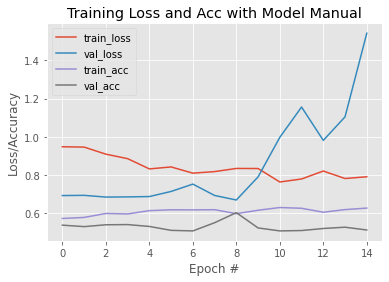

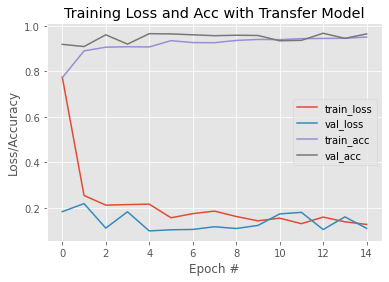

In [24]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), h.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), h.history["val_acc"], label="val_acc")
plt.title("Training Loss and Acc with Model Manual")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.figure()
plt.plot(np.arange(0, EPOCHS), h_transfer.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), h_transfer.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), h_transfer.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), h_transfer.history["val_acc"], label="val_acc")
plt.title("Training Loss and Acc with Transfer Model")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

**Note:** As we can see, the accuarncy of model manual lower than model transfer at the start point or after train. So in the reality, we usually use transfer model to optimizer the time and loss trainning

In [25]:
generate_train_data.class_indices

{'cats': 0, 'dogs': 1}

Saving 98919193e0f629a870e7.jpg to 98919193e0f629a870e7.jpg
(1, 150, 150, 3)
Model Manual:  Cat
Model Transfer:  Dog


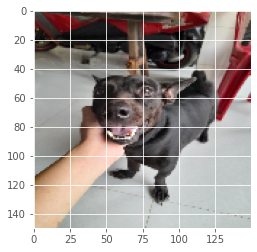

In [30]:
file_upload = files.upload()
for fn in file_upload.keys():
    path = './' + fn
    img = image.load_img(path, target_size = (150, 150))
    x = image.img_to_array(img) / 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    print(images.shape)
    classes = model.predict(images, batch_size=10)
    classes_transfer = model_transfer.predict(images, batch_size=10)
    predict = "Cat"
    predict_transfer = "Cat"

    if classes[0] > 0.5:
      predict = "Dog"
    if classes_transfer[0] > 0.5:
       predict_transfer = "Dog";
    plt.imshow(img)
    print("Model Manual: ", predict)
    print("Model Transfer: ", predict_transfer)

In [27]:
tfjs_model_path = 'model/tfjs'

In [28]:
model.save("model_manual.h5")
tfjs.converters.save_keras_model(model, tfjs_model_path + "/manual")

In [29]:
model_transfer.save("model_transfer.h5")
tfjs.converters.save_keras_model(model_transfer, tfjs_model_path + "/transfer")

# Expand
This is some code to show predict progress when model train, but we can't know how model use data to train or which attribute of image learn by model.

In [31]:
output_manual_layers = [layer.output for layer in model.layers]
layers_manual_name = [layer.name for layer in model.layers]

In [32]:
output_transfer_layers = [layer.output for layer in model_transfer.layers]
layers_transfer_name = [layer.name for layer in model_transfer.layers]

In [33]:
visualize_model_manual = Model(inputs = model.input, outputs = output_manual_layers)
visualize_model_transfer = Model(inputs = model_transfer.input, outputs = output_transfer_layers)

Saving 3180-Pug_green_grass-732x549-thumbnail-732x549.jpg to 3180-Pug_green_grass-732x549-thumbnail-732x549.jpg


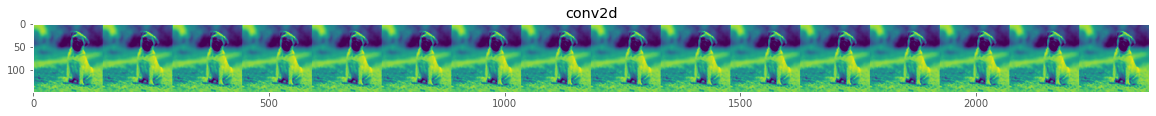

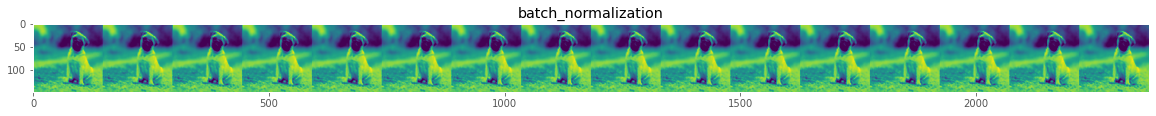

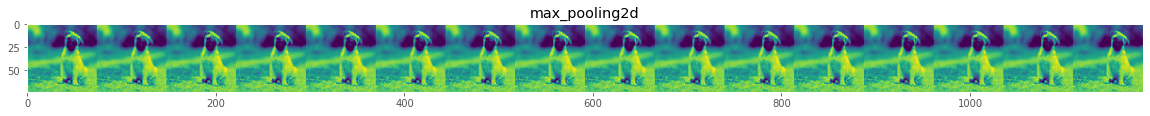

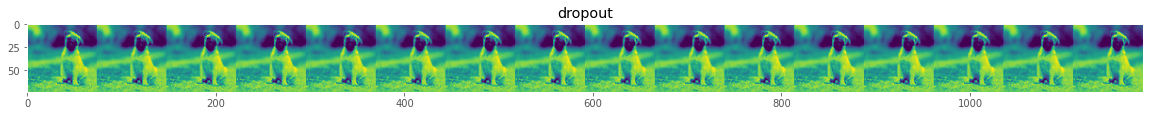

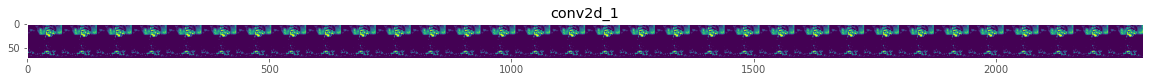

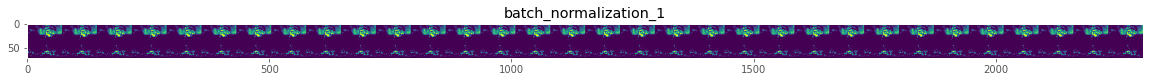

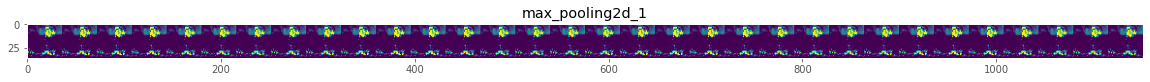

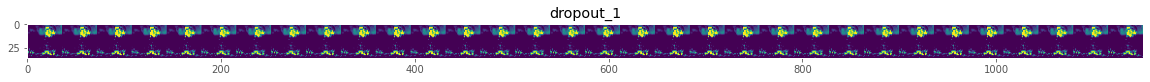

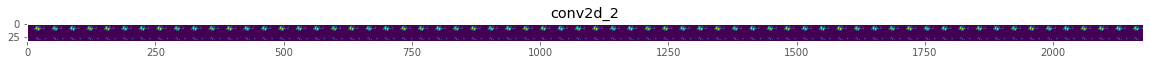

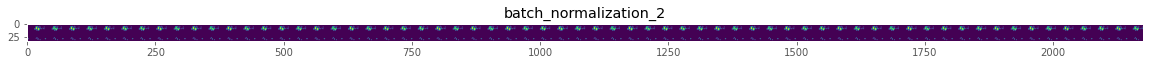

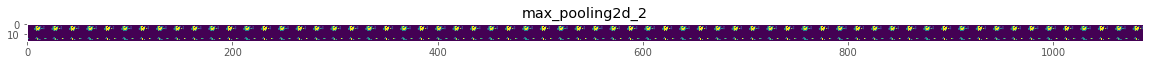

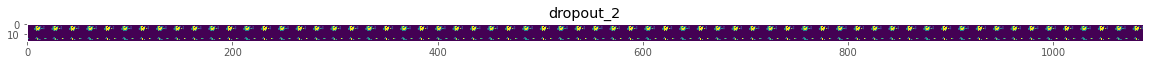

In [34]:
file_upload = files.upload()
for fn in file_upload.keys():
    path = './' + fn
    img = image.load_img(path, target_size = (150, 150))
    x = image.img_to_array(img) / 255
    x = x.reshape((1,) + x.shape)
    feature_maps = visualize_model_manual.predict(x)
    feature_transfer_map = visualize_model_transfer.predict(x)
    for layer_manual_name, feature_map in zip(layers_manual_name, feature_maps):
      if len(feature_map.shape) == 4:
        n_feature = feature_map.shape[-1]
        size = feature_map.shape[1]
        display = np.zeros((size, size * n_feature))
        for i in range(n_feature):
          x = feature_map[0, :, :, 1]
          x -= x.mean()
          x /= x.std()
          x *= 64
          x += 128
          x = np.clip(x, 0, 255).astype("uint8")
          display[:, i * size : (i + 1) * size] = x
        scale = 20. / n_feature
        plt.figure(figsize=(scale * n_feature, scale))
        plt.title(layer_manual_name)
        plt.grid(False)
        plt.imshow(display, aspect='auto', cmap='viridis')